## Bitcoin Price Predictions Using Facebook Prophet

From the Facebook Prophet documentation and white paper:

- additive regression model: piecewise linear or logistic growth curve trend
- seasonal components modeled using Fourier series and dummy variables
- accurate changepoint detection
- incorporates MCMC sampling to determine uncertainties in trends

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

#### ...`numpy` has an issue with `datetime` object

- I had to create a new plotting function to see confidence regions
- This also allows me to plot the true values for the test data too

In [35]:
# define new plotting function that shows comparison to test data
def plot_forecast(fulldat, fcst, log_return=True, logistic=False, tickinterval="mins", ylabel="logPrice"):
    
    if tickinterval == "days":
        datxs = (pd.to_datetime(fulldat.date) - pd.to_datetime(fulldat.date)[0]).dt.days
        fxs = (pd.to_datetime(fcst.ds) - pd.to_datetime(fulldat.date)[0]).dt.days
    elif tickinterval == "hours":
        datxs = (pd.to_datetime(fulldat.date) - pd.to_datetime(fulldat.date)[0]).dt.total_seconds() / 3600
        fxs = (pd.to_datetime(fcst.ds) - pd.to_datetime(fulldat.date)[0]).dt.total_seconds() / 3600
    elif tickinterval == "mins":
        datxs = (pd.to_datetime(fulldat.date) - pd.to_datetime(fulldat.date)[0]).dt.total_seconds() / 60
        fxs = (pd.to_datetime(fcst.ds) - pd.to_datetime(fulldat.date)[0]).dt.total_seconds() / 60
    
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    if log_return:
        ax.plot(datxs, np.log(fulldat.close), 'k.')
    else:
        ax.plot(datxs, fulldat.close, 'k.')
        
    ax.plot(fxs, fcst['yhat'], ls='-', c='#0072B2')
    
    if logistic:
        ax.plot(fxs, fcst['cap'], ls='--', c='k')
        ax.plot(fxs, fcst['floor'], ls='--', c='k')
        
    ax.fill_between(fxs, fcst['yhat_lower'],
                    fcst['yhat_upper'], color='#0072B2',
                    alpha=0.2)
    
    ax.set_xlabel(tickinterval)
    ax.set_ylabel(ylabel)
    
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
    fig.tight_layout()

### Problem setup

- pull in scraped bitcoin price data from the bittrex exchange
- train prophet on an earlier portion of the data
- compare projections from the prophet with the actual closing prices that transpired
- ???
- Profit/Prophet

#### so here's the code to set up my training data:

In [14]:
def mk_train(df, start, end, log_return=True, capfac=2, floorfac=0.5):
    
    trainday = pd.DataFrame()
    
    if log_return:
        trainday["y"] = np.log(df.close[start:end])
        trainday["cap"] = np.log(capfac * df.high[start:end])
        trainday["floor"] = np.log(floorfac * df.low[start:end])
        trainday["ds"] = df.date
    else:
        trainday["y"] = df.close[start:end]
        trainday["cap"] = capfac * df.high[start:end]
        trainday["floor"] = floorfac * df.low[start:end]
        trainday["ds"] = df.date
        
    return trainday

#### First, I load in daily closing prices from the exchange

#### Then, set up the `Prophet` object

In [30]:
# load a timeseries
btc_day = pd.read_csv("../dat/bittrex/tickdat/usdt_btc_day.csv")
print(btc_day.shape)

# get start and end of training data
datN = btc_day.shape[0]
start = 0
end = 350
trainlen = end - start

# make a training dataframe
trainday = mk_train(btc_day, start, end)

# set up prophet object and train on test data
m = Prophet()
m.fit(trainday)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(645, 8)


In [31]:
# compare with non-log
trainlin = mk_train(btc_day, start, end, log_return=False)

# set up prophet object and train on test data
mlin = Prophet()
mlin.fit(trainlin)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
# create a prediction dataframe
f = m.make_future_dataframe(periods=datN - end)
# f["cap"] = trainday.cap.max() + trainday.cap.std()
# f.loc[:trainlen, ["cap"]] = trainday["cap"]
# run the forecast
fcst = m.predict(f)

In [33]:
# and linear
flin = mlin.make_future_dataframe(periods=datN - end)
# flin["cap"] = trainday.cap.max() + trainday.cap.std()
# flin.loc[:trainlen, ["cap"]] = trainday["cap"]
# run the forecast
lincst = mlin.predict(flin)

#### Training on raw price data does not do too well....

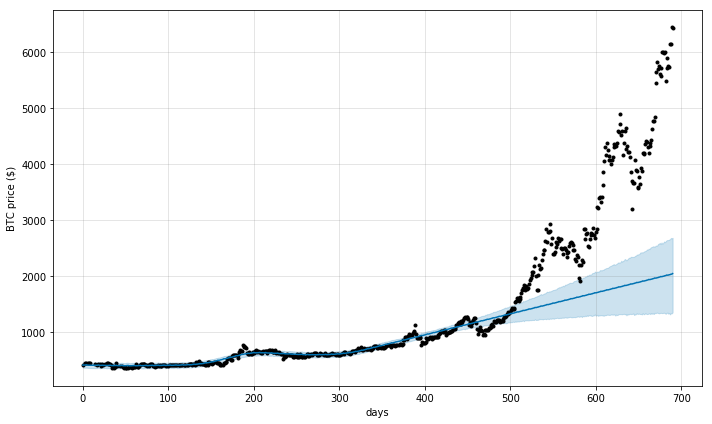

In [36]:
# First let's see the linear plot
plot_forecast(btc_day, lincst, log_return=False, tickinterval="days", ylabel="BTC price ($)")

#### Need to take the log price to train on returns, as is standard in financial analysis:

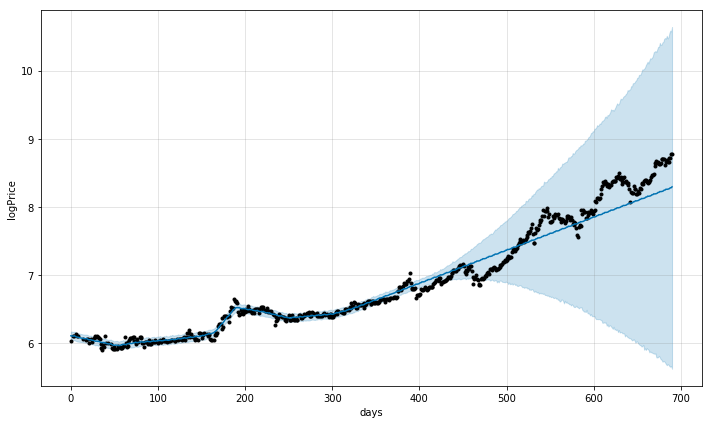

In [39]:
plot_forecast(btc_day, fcst, tickinterval="days")

### Let's try with hourly data!


In [45]:
# how about hourly data
btc_hour = pd.read_csv("../dat/bittrex/tickdat/usdt_btc_hour.csv")
print(btc_hour.shape)

# get start and end of training data
datN = btc_hour.shape[0]
start = 0
end = 1200
trainlen = end - start

# make a training dataframe
trainhour = mk_train(btc_hour, start, end)

# set up prophet object and train on test data
m = Prophet()  # mcmc_samples=100)
m.fit(trainhour)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(1440, 8)


In [46]:
# create a prediction dataframe
f = m.make_future_dataframe(periods=datN - end, freq="H")

# run the forecast
fcst = m.predict(f)

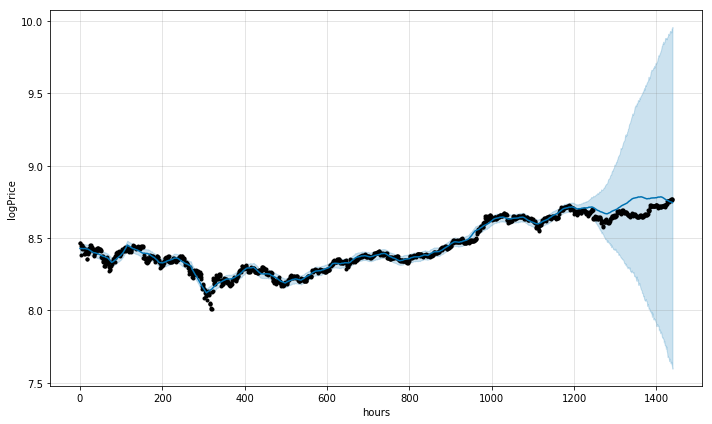

In [47]:
plot_forecast(btc_hour, fcst, tickinterval="hours")

In [24]:
# create a prediction dataframe
f = m.make_future_dataframe(periods=datN - end, freq="H")

# run the forecast
fcst = m.predict(f)



### This time including some MCMC sampling

#### Get's slightly tighter uncertainty estimates

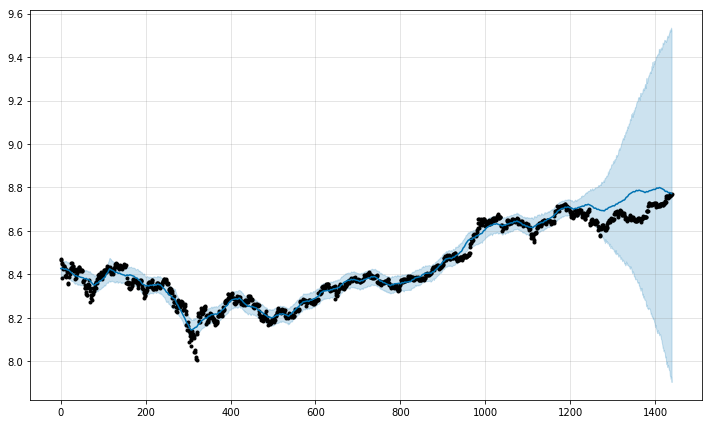

In [25]:
plot_forecast(btc_hour, fcst, tickinterval="hours")

#### And allows us to make sample draws from the posterior!

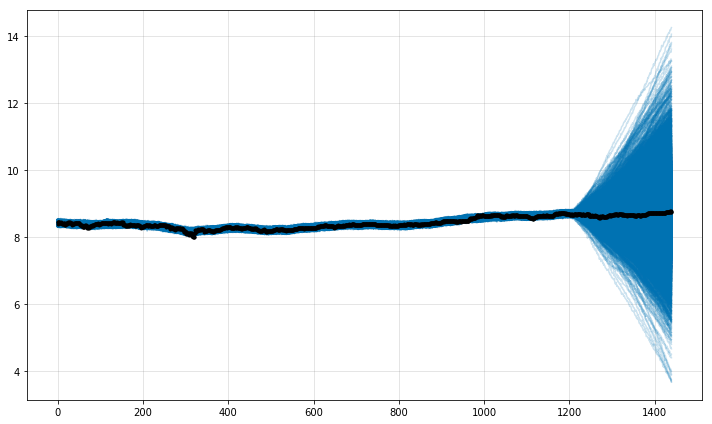

In [26]:
datxs = (pd.to_datetime(btc_hour.date) - pd.to_datetime(btc_hour.date)[0]).dt.total_seconds() / 3600
fxs = (pd.to_datetime(fcst.ds) - pd.to_datetime(btc_hour.date)[0]).dt.total_seconds() / 3600
        
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

for i in range(30):
    ax.plot(fxs, m.predictive_samples(f)["yhat"],ls='-', c='#0072B2', alpha=0.2)
    
ax.plot(datxs, np.log(btc_hour.close), 'k.')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

fig.tight_layout()

### But... Facebook prophet only makes predictions on the scale of one hour however

#### Here I see what happens if I look at the closing prices on a minute time scale

In [41]:
# and minutes
btc_mins = pd.read_csv("../dat/bittrex/tickdat/usdt_btc_oneMin.csv")
print(btc_mins.shape)

# get start and end of training data
datN = btc_mins.shape[0]
start = 0
end = 12000
trainlen = end - start

# make a training dataframe
trainmins = mk_train(btc_mins, start, end)

# set up prophet object and train on test data
m = Prophet()
m.fit(trainmins)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


(14235, 8)


In [42]:
# create a prediction dataframe
f = m.make_future_dataframe(periods=int(np.floor((datN - end) / 60)), freq="H")
f["cap"] = trainhour.cap.max() + trainday.cap.std()
f.loc[:trainlen, ["cap"]] = trainhour["cap"]

# run the forecast
fcst = m.predict(f)

### Predictions can only be made on an hourly basis, so we plot with respect to that

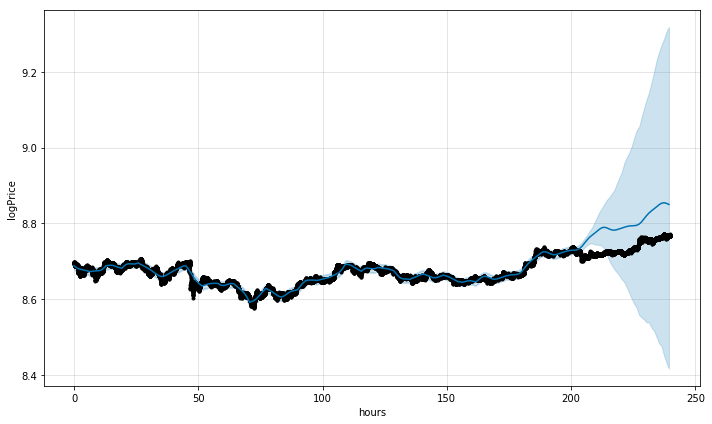

In [43]:
plot_forecast(btc_mins, fcst, tickinterval="hours")

### Let's make a stab with some Ethereum data
#### It hasn't had such an enormous growth curve

In [49]:
# how about hourly data
eth_hour = pd.read_csv("../dat/bittrex/tickdat/usdt_eth_hour.csv")
print(eth_hour.shape)

# get start and end of training data
datN = eth_hour.shape[0]
start = 0
end = 1200
trainlen = end - start

# make a training dataframe
trainhour = mk_train(eth_hour, start, end)

# set up prophet object and train on test data
m = Prophet()  # mcmc_samples=100)
m.fit(trainhour)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(1440, 8)


In [50]:
# create a prediction dataframe
f = m.make_future_dataframe(periods=datN - end, freq="H")

# run the forecast
fcst = m.predict(f)

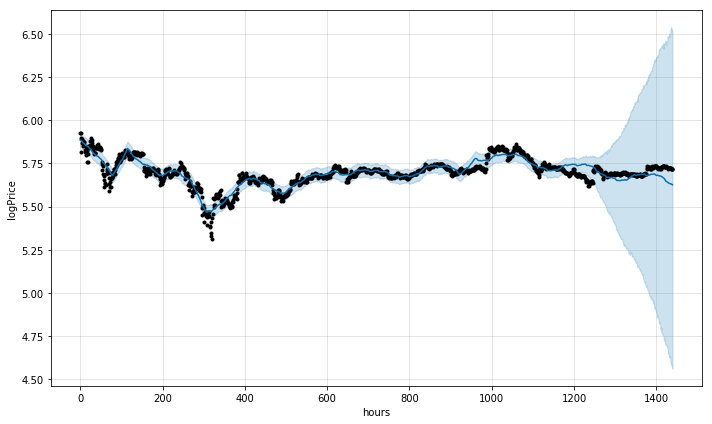

In [52]:
plot_forecast(eth_hour, fcst, tickinterval="hours")